Imports, path definitions and study-level definitions.

In [4]:
import os
import numpy as np
from sklearn.decomposition import PCA


In [5]:
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

path_preprocessed = project_root/"data/preprocessed/eeg"
path_output = project_root/"data/output/pca"
path_results = project_root/"data/results/eeg"

In [6]:
# Channel labels (fixed order!)
channels_labels = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", "T7",
    "C3", "C4", "T8", "TP9", "CP5", "CP1", "CP2", "CP6", "TP10", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2", "Iz", "AF7", "AF3", "AFz", "AF4",
    "AF8", "F5", "F1", "F2", "F6", "FT7", "FC3", "FCz", "FC4", "FT8", "C5", "C1",
    "C2", "C6", "TP7", "CP3", "CPz", "CP4", "TP8", "P5", "P1", "P2", "P6", "PO7",
    "PO3", "POz", "PO4", "PO8"
]

n_channels = len(channels_labels)
assert n_channels == 62, "Expected 62 EEG channels (64 total - 2 reference channels)"

subjects = [f"{i:02d}" for i in range(1, 25)]
tasks = ["S1", "S2", "S3", "S4", "S5", "S6", "S7"]


In [7]:
# User parameters
n_channels = 62      # number of channels after removing A1/A2
variance_threshold = 0.8  # PCA variance to retain
n_splits = 5         # within-subject CV folds

# Compute channel-level PCA features per epoch
def compute_channel_features_epoch(eeg_epoch, variance_threshold=0.8):
    """
    eeg_epoch: ndarray (channels × samples_epoch)
    Returns:
        feat: ndarray (channels,)
        patterns: ndarray (channels × components)
        explained_var: ndarray (components,)
    """
    eeg_centered = eeg_epoch - eeg_epoch.mean(axis=1, keepdims=True)
    X = eeg_centered.T
    pca = PCA()
    _ = pca.fit_transform(X)
    cumulative_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_var, variance_threshold) + 1
    W = pca.components_[:n_components].T
    explained_var = pca.explained_variance_ratio_[:n_components]
    cov_matrix = np.cov(eeg_centered)
    patterns = cov_matrix @ W
    feat = np.sum(np.abs(patterns) * explained_var[np.newaxis, :], axis=1)
    return feat


Assemble dataset.

In [8]:
# Collect subject-wise data
subject_files = {}

for filename in os.listdir(path_preprocessed):
    if not filename.endswith("_preprocessed.npy"):
        continue

    parts = filename.split("_")
    task_label = parts[0]      # S1..S7
    subj_label = parts[1]      # e.g. 01
    filepath = os.path.join(path_preprocessed, filename)

    # Load epochs: (n_epochs, channels, samples)
    epochs = np.load(filepath)

    if epochs.ndim != 3:
        raise ValueError(f"{filename}: expected 3D array, got shape {epochs.shape}")

    n_epochs_file, n_channels_file, n_samples_file = epochs.shape
    assert n_channels_file == n_channels, "Channel mismatch"

    print(
        f"Processing subject {subj_label}, task {task_label}: "
        f"{n_epochs_file} epochs, {n_channels_file} channels, {n_samples_file} samples"
    )

    if subj_label not in subject_files:
        subject_files[subj_label] = []

    for ep in epochs:
        feat = compute_channel_features_epoch(ep, variance_threshold)
        subject_files[subj_label].append((feat, task_label))



Processing subject 11, task S2: 10 epochs, 62 channels, 7500 samples
Processing subject 08, task S4: 10 epochs, 62 channels, 7500 samples
Processing subject 13, task S2: 10 epochs, 62 channels, 7500 samples
Processing subject 04, task S5: 10 epochs, 62 channels, 7500 samples
Processing subject 14, task S2: 10 epochs, 62 channels, 7500 samples
Processing subject 09, task S1: 10 epochs, 62 channels, 7500 samples
Processing subject 17, task S5: 10 epochs, 62 channels, 7500 samples
Processing subject 08, task S2: 10 epochs, 62 channels, 7500 samples
Processing subject 14, task S5: 10 epochs, 62 channels, 7500 samples
Processing subject 10, task S5: 10 epochs, 62 channels, 7500 samples
Processing subject 14, task S3: 10 epochs, 62 channels, 7500 samples
Processing subject 07, task S7: 10 epochs, 62 channels, 7500 samples
Processing subject 15, task S3: 10 epochs, 62 channels, 7500 samples
Processing subject 17, task S6: 10 epochs, 62 channels, 7500 samples
Processing subject 16, task S3: 10

Classification within subject.

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score
)

# ------------------------
# Parameters
# ------------------------
n_splits = 5
random_state = 0
n_permutations = 50
n_bootstrap = 100

results = {}

# ========================
# SUBJECT LOOP
# ========================
for subj_label, ep_list in subject_files.items():

    print(f"Processing subject {subj_label}")

    X = np.vstack([x[0] for x in ep_list])   # (epochs × channels)
    y = np.array([x[1] for x in ep_list])    # task labels

    classes, counts = np.unique(y, return_counts=True)
    n_classes = len(classes)
    n_channels = X.shape[1]

    if np.any(counts < n_splits):
        raise ValueError(
            f"Subject {subj_label}: not enough samples per class for {n_splits}-fold CV"
        )

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", OneVsRestClassifier(
            LogisticRegression(max_iter=5000, n_jobs=-1, class_weight="balanced")
        ))
    ])

    # ------------------------
    # Metric storage
    # ------------------------
    metrics_overall = {  # Weighted overall metrics
        "accuracy": [],
        "balanced_accuracy": [],
        "f1_weighted": [],
        "recall_weighted": [],
        "precision_weighted": [],
        "roc_auc_weighted": []
    }

    per_task_metrics = {
        c: {
            "accuracy": [],
            "f1": [],
            "sensitivity": [],
            "specificity": [],
            "roc_auc": []
        } for c in classes
    }

    # ------------------------
    # Channel importance storage
    # ------------------------
    weight_importance_folds = {c: [] for c in classes}
    perm_importance_raw = []

    # ========================
    # CROSS-VALIDATION LOOP
    # ========================
    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
        ovr = clf.named_steps["clf"]
        class_to_idx = {c: i for i, c in enumerate(ovr.classes_)}
        coefs = np.vstack([
            ovr.estimators_[class_to_idx[c]].coef_.ravel()
            for c in classes
        ])

        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)

        # ------------------------
        # Overall weighted metrics
        # ------------------------
        metrics_overall["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics_overall["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
        metrics_overall["f1_weighted"].append(f1_score(y_test, y_pred, average="weighted", zero_division=0))
        metrics_overall["recall_weighted"].append(recall_score(y_test, y_pred, average="weighted", zero_division=0))
        metrics_overall["precision_weighted"].append(precision_score(y_test, y_pred, average="weighted", zero_division=0))
        metrics_overall["roc_auc_weighted"].append(
            roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
        )

        # ------------------------
        # Per-task metrics
        # ------------------------
        for i, c in enumerate(classes):
            y_true_bin = (y_test == c).astype(int)
            y_pred_bin = (y_pred == c).astype(int)
            y_proba_bin = y_proba[:, i]

            tn, fp, fn, tp = 0,0,0,0
            if np.unique(y_true_bin).size == 2:
                tn, fp, fn, tp = np.ravel(confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]))
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            per_task_metrics[c]["accuracy"].append((tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn)>0 else np.nan)
            per_task_metrics[c]["f1"].append(f1_score(y_true_bin, y_pred_bin, zero_division=0))
            per_task_metrics[c]["sensitivity"].append(sensitivity)
            per_task_metrics[c]["specificity"].append(specificity)
            if np.unique(y_true_bin).size == 2:
                per_task_metrics[c]["roc_auc"].append(roc_auc_score(y_true_bin, y_proba_bin))
            else:
                per_task_metrics[c]["roc_auc"].append(np.nan)

            # ------------------------
            # Weight-based importance per task
            # ------------------------
            weight_importance_folds[c].append(np.abs(coefs[i]))

        # ------------------------
        # Permutation importance
        # ------------------------
        baseline = balanced_accuracy_score(y_test, y_pred)
        for ch in range(n_channels):
            X_perm = X_test.copy()
            np.random.shuffle(X_perm[:, ch])
            y_perm = clf.predict(X_perm)
            drop = baseline - balanced_accuracy_score(y_test, y_perm)
            perm_importance_raw.append((ch, drop))

    # ========================
    # Aggregate results
    # ========================
    # Overall metrics
    results[subj_label] = {
        "overall": {metric: {"mean": np.nanmean(vals), "std": np.nanstd(vals)}
                    for metric, vals in metrics_overall.items()},
        "per_task": {c: {metric: {"mean": np.nanmean(vals), "std": np.nanstd(vals)}
                         for metric, vals in per_task_metrics[c].items()}
                     for c in classes},
    }

    # Channel importance
    # Weight-based
    results[subj_label]["channel_importance"] = {
        "weights": {c: np.mean(weight_importance_folds[c], axis=0) for c in classes}
    }

    # Permutation importance
    perm_importance = np.zeros(n_channels)
    counts = np.zeros(n_channels)
    for ch, drop in perm_importance_raw:
        perm_importance[ch] += drop
        counts[ch] += 1
    perm_importance /= counts
    results[subj_label]["channel_importance"]["permutation"] = perm_importance

    # Haufe patterns
    clf.fit(X, y)
    ovr = clf.named_steps["clf"]
    class_to_idx = {c: i for i, c in enumerate(ovr.classes_)}
    W = np.vstack([ovr.estimators_[class_to_idx[c]].coef_.ravel() for c in classes])
    Sigma = np.cov(X, rowvar=False)
    haufe_patterns = {c: Sigma @ W[i] for i, c in enumerate(classes)}
    results[subj_label]["channel_importance"]["haufe"] = haufe_patterns

    # Stability selection
    stability_raw = {c: [] for c in classes}
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y), size=len(y), replace=True)
        clf.fit(X[idx], y[idx])
        ovr = clf.named_steps["clf"]
        Wb = np.vstack([ovr.estimators_[class_to_idx[c]].coef_.ravel() for c in classes])
        stability_raw = {c: stability_raw[c] + [np.abs(Wb[i])] for i,c in enumerate(classes)}
    stability = {c: {"mean": np.mean(stability_raw[c], axis=0),
                     "std": np.std(stability_raw[c], axis=0)} for c in classes}
    results[subj_label]["channel_importance"]["stability"] = stability


Processing subject 11
Processing subject 08
Processing subject 13
Processing subject 04
Processing subject 14
Processing subject 09
Processing subject 17
Processing subject 10
Processing subject 07
Processing subject 15
Processing subject 16
Processing subject 01
Processing subject 21
Processing subject 24
Processing subject 05
Processing subject 18
Processing subject 12
Processing subject 20
Processing subject 02
Processing subject 22
Processing subject 23
Processing subject 06
Processing subject 19
Processing subject 03


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metrics_boxscatter(results, subjects, metrics_to_plot, title="", ylabel=""):
    """
    Plot boxplots of metrics across subjects, with scatter per subject.
    
    results: dict from your pipeline
    subjects: list of subject IDs
    metrics_to_plot: list of strings, keys of results[subj]["overall"]
    """
    n_metrics = len(metrics_to_plot)
    data = [ [results[s]["overall"][m]["mean"] for s in subjects] for m in metrics_to_plot ]

    plt.figure(figsize=(3*n_metrics, 5))
    
    bp = plt.boxplot(data, labels=metrics_to_plot, patch_artist=True, widths=0.5)
    
    # Add scatter for each subject
    for i, d in enumerate(data):
        plt.scatter([i+1]*len(d), d, color='k', alpha=0.6)
    
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Performance (per subject), mean & median marked

/tmp/ipykernel_25500/858925178.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=metrics_to_plot, patch_artist=True, widths=0.5)


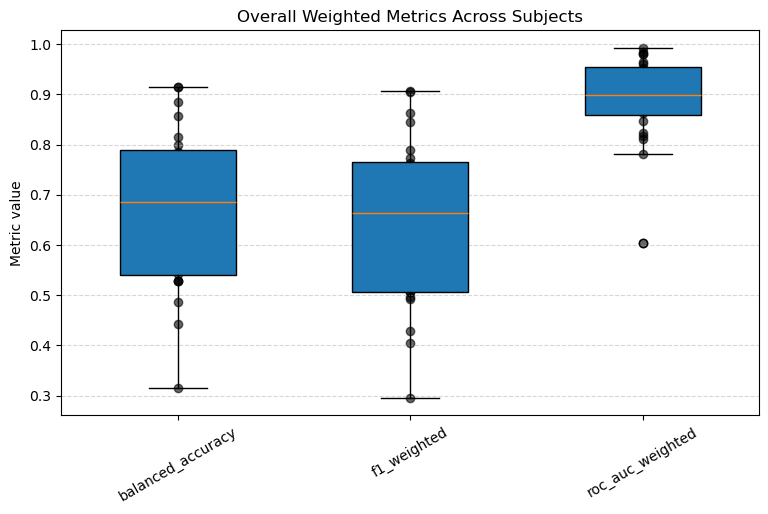

In [18]:
subjects_list = list(results.keys())
metrics_to_plot = ["balanced_accuracy", "f1_weighted", "roc_auc_weighted"]

plot_metrics_boxscatter(
    results,
    subjects_list,
    metrics_to_plot,
    title="Overall Weighted Metrics Across Subjects",
    ylabel="Metric value"
)


Accuracy per task (across subjects)

In [20]:
def plot_per_task_metrics(results, subjects, tasks, metric="accuracy", title=""):
    """
    Plot boxplots per task with scatter per subject.
    
    results: your results dict
    tasks: list of task names (e.g., S1..S7)
    metric: metric key in results[subj]["per_task"][task]
    """
    data = []
    for t in tasks:
        vals = []
        for s in subjects:
            vals.append(results[s]["per_task"][t][metric]["mean"])
        data.append(vals)
    
    plt.figure(figsize=(12,5))
    bp = plt.boxplot(data, labels=tasks, patch_artist=True)
    
    # Scatter per subject
    for i, vals in enumerate(data):
        plt.scatter([i+1]*len(vals), vals, color='k', alpha=0.6)
    
    plt.ylabel(metric.replace("_"," ").title())
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


Task-wise accuracy

/tmp/ipykernel_25500/2497405984.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=tasks, patch_artist=True)


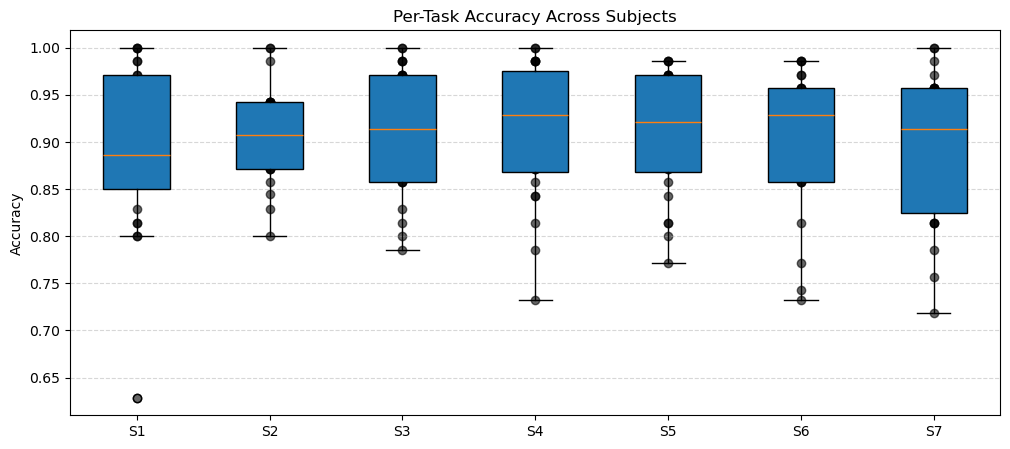

/tmp/ipykernel_25500/2497405984.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=tasks, patch_artist=True)


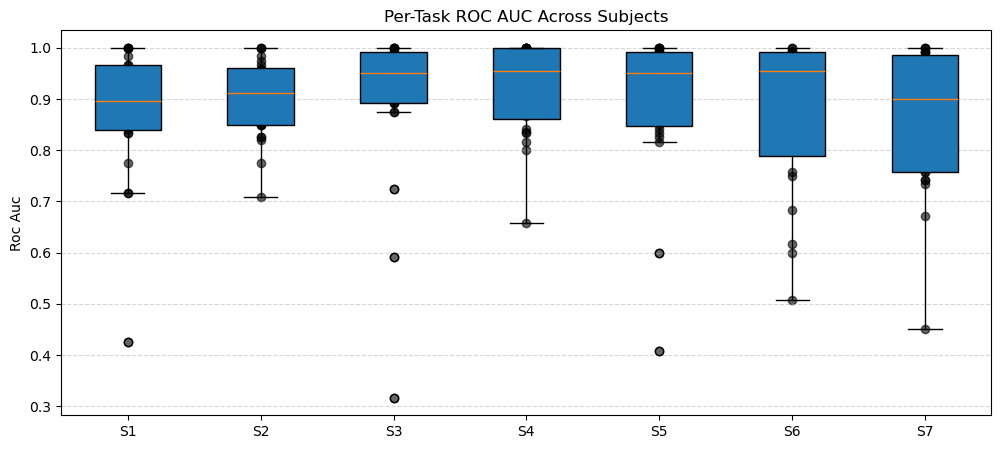

In [21]:
tasks_list = ["S1","S2","S3","S4","S5","S6","S7"]
plot_per_task_metrics(results, subjects_list, tasks_list, metric="accuracy", title="Per-Task Accuracy Across Subjects")
plot_per_task_metrics(results, subjects_list, tasks_list, metric="roc_auc", title="Per-Task ROC AUC Across Subjects")


In [22]:
def plot_channel_importance(results, subjects, channels_labels, method="weights"):
    """
    method: "weights", "permutation", or "haufe"
    """
    n_channels = len(channels_labels)
    # Collect across subjects
    if method == "haufe":
        # average absolute value across classes
        data = np.zeros((len(subjects), n_channels))
        for i, s in enumerate(subjects):
            subj_data = results[s]["channel_importance"][method]
            # Average across classes
            data[i,:] = np.mean([np.abs(subj_data[c]) for c in subj_data], axis=0)
    elif method == "weights":
        data = np.zeros((len(subjects), n_channels))
        for i, s in enumerate(subjects):
            subj_data = results[s]["channel_importance"][method]
            data[i,:] = np.mean([subj_data[c] for c in subj_data], axis=0)
    elif method == "permutation":
        data = np.zeros((len(subjects), n_channels))
        for i, s in enumerate(subjects):
            data[i,:] = results[s]["channel_importance"][method]
    else:
        raise ValueError("Unknown method")
    
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    plt.figure(figsize=(15,4))
    plt.bar(np.arange(n_channels), mean_vals, yerr=std_vals, alpha=0.7)
    plt.xticks(np.arange(n_channels), channels_labels, rotation=90)
    plt.ylabel("Channel importance")
    plt.title(f"Channel importance ({method}) averaged across subjects")
    plt.tight_layout()
    plt.show()


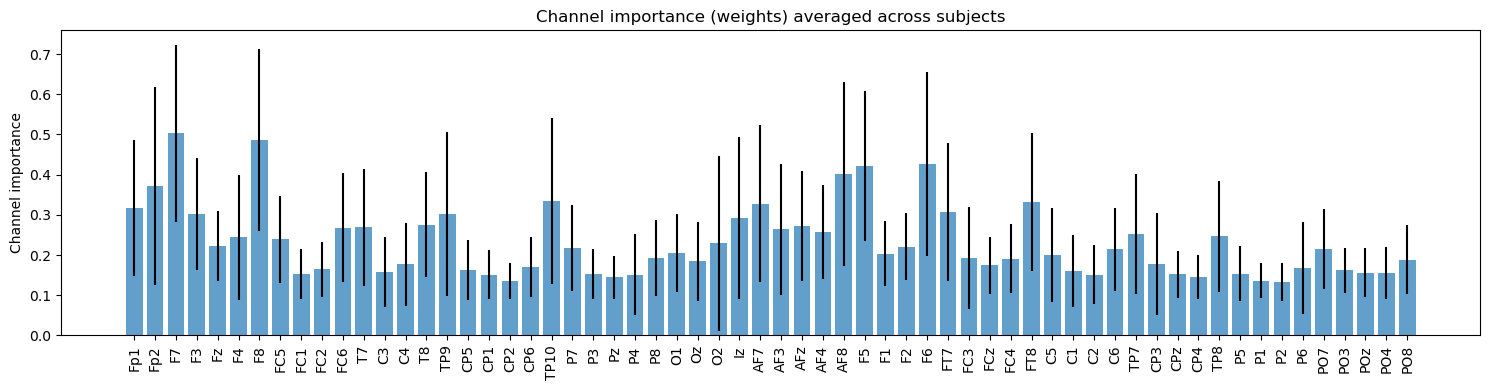

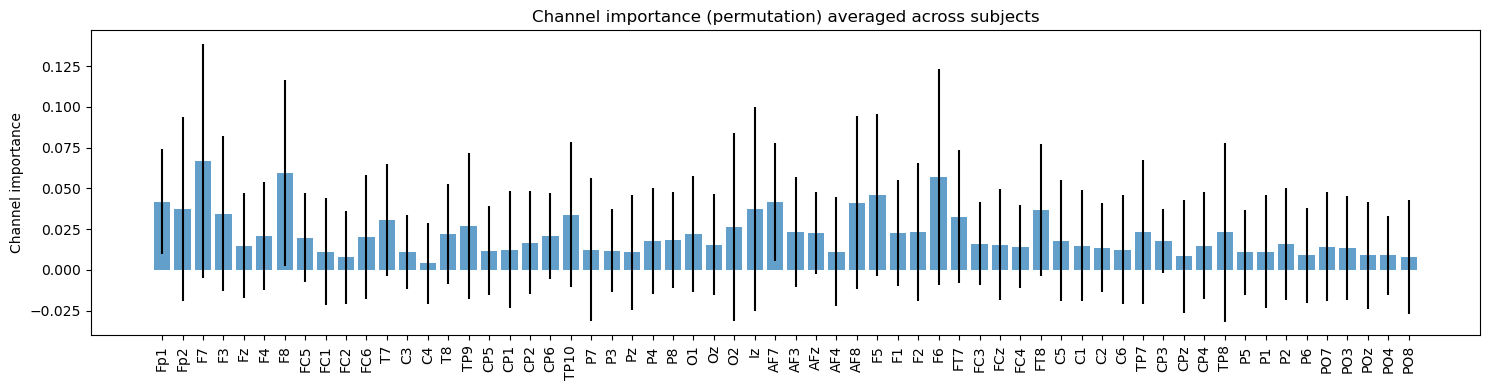

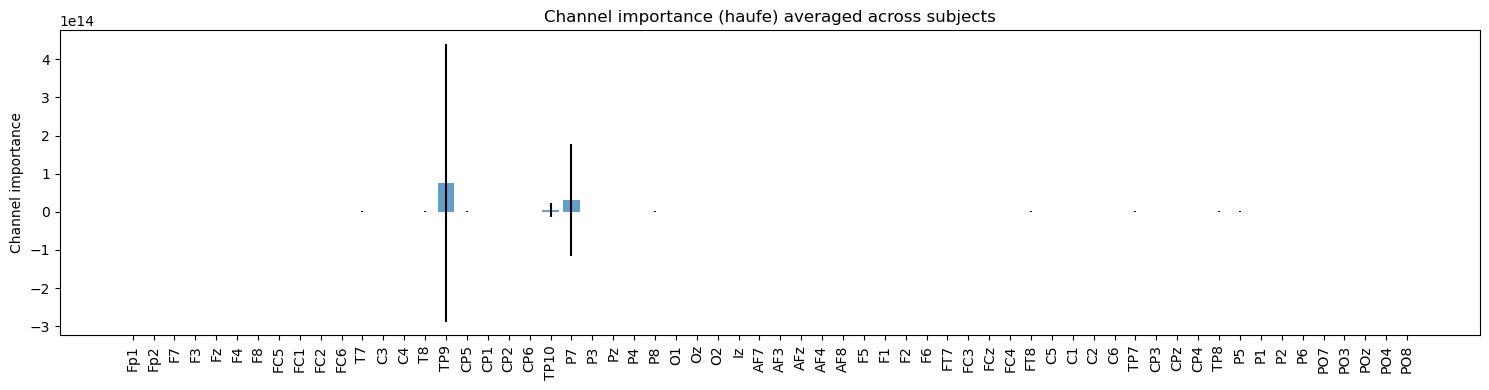

In [23]:
plot_channel_importance(results, subjects_list, channels_labels, method="weights")
plot_channel_importance(results, subjects_list, channels_labels, method="permutation")
plot_channel_importance(results, subjects_list, channels_labels, method="haufe")
